# Анализ лояльности пользователей Яндекс Афиши

- Автор: Перевалова Юлия Сргеевна
- Дата: 13.11.2025 г.

# Цели и задачи проекта

**Цель:** Провести исследовательский анализ пользователей Яндекс Афиши с целью выявить какие пользователи с большей вероятностью возвращаются на платформу и делают повторные заказы.

**Задачи:**

1. Написать SQL запрос для выгрузки датафрейма в pandas:
2. Загрузить данные и познакомиться с их содержимым.
3. Привести выручку к единой валюте - российскому рублю.
4. Провести предобработку данных.
5. Создать профиль пользователя.
6. Изучить репрезентативность данных в выборке.
7. Провести исследовательский анализ данных:
    - изучить признаки первого заказа и их связь с возвращением на платформу;
    - изучить зависимость выручки от заказа и его состава с возвращением на платформу;
    - изучить зависимость временных характеристик первого заказа от возвращения на платформу;
    - провести корелляционный анализ количества покупок и признаков пользователя.
8. Сформулировать выводы и рекомендации по проведенному анализу.
9. Публикация проекта в Git.

    


## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для 

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
# Установим библиотеку для подключения к БД
!pip install sqlalchemy

In [4]:
# Произведем установку модуля psycopg2 он также необходим для подключения к БД
!pip install psycopg2-binary

In [5]:
!pip install phik

In [6]:
# Импортируем остальные библиотеки и функции, которые понадобятся нам при выполнении проекта
import pandas as pd
from sqlalchemy import create_engine

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [7]:
# Данные для подключения переместили в файл .env

In [8]:
# Формируем строку для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [9]:
# Передаем строку для подключения функции create_engine
engine = create_engine(connection_string)

In [10]:
# Запишем запрос в переменную
query = '''
SELECT
a.user_id,
a.device_type_canonical,
a.order_id,
a.created_dt_msk as order_dt,
a.created_ts_msk as order_ts,
a.currency_code,
a.revenue,
a.tickets_count,
extract(day from a.created_dt_msk-lag(a.created_dt_msk) over (partition by a.user_id order by a.created_dt_msk)) as days_since_prev,
a.event_id,
e.event_name_code as event_name,
e.event_type_main,
a.service_name,
r.region_name,
c.city_name
from afisha.purchases a
left join afisha.events e on a.event_id=e.event_id
left join afisha.city c on e.city_id = c.city_id 
left join afisha.regions r on c.region_id=r.region_id
where a.device_type_canonical in ('desktop', 'mobile') and e.event_type_main <> 'фильм'
order by user_id
'''

In [11]:
# Записываем результат выполнения запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [12]:
# Выводим первые строки датафрейма на экран
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [13]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Датасет df содержит 14 столбцов и 290 611 строк, что соответсвует количеству строк в sql запросе. В датасете представлена информация о покупаках пользователей билетов на различные мероприятия на платформе Яндекс Афиши.

После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов приведены к одному виду snake case.
- Данные содержат числовые (float64, int64), строковые (object8)  и значения в формате дат (datetime64[ns]). У столбцов в order_id, revrnue, tickets_count, days_snice_prev и event_id можно понизить разрядность.
- Пропуски содержатся только в столбце days_snice_prev у тех клиентов у которых не было предыдущего заказа. Однако следует проверить и другие столбцы: в них могут встречаться значения-индикаторы, которые будут говорить об отсутствии данных.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [14]:
# Выгружаем данные в переменную df_revenue
df_revenue = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [15]:
# Приводим столбец data к типу данных даты чтобы объединить дафреймы
df_revenue['data']=pd.to_datetime(df_revenue['data'])

In [16]:
# Соединяем данные в единый датафрейм df
df = df.merge(df_revenue, left_on='order_dt', right_on = 'data', how='left')

In [17]:
# Переводим тенге в рубли и создаем новый столбец с выручкой в рублях
def rub_revenue(row):
    if row['currency_code'] =='kzt':
        return row['revenue'] / 100 * row['curs']
    else:
        return row['revenue']

df['revenue_rub'] = df.apply(rub_revenue, axis=1)

In [18]:
# Проверяем
df[(df['currency_code']=='kzt')].head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-17,100,19.0125,kzt,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-02,100,18.9330,kzt,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-09,100,18.5991,kzt,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,2024-06-11,100,19.8928,kzt,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833,kzt,1478.296591


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [19]:
# создаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
temp = df.copy() 
len(temp)

290611

In [20]:
# Проанализируем пропуски в столбцах
def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean()
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    # Форматируем при выводе через Styler
    return (missing_stats.style.format({'Доля пропусков': '{:.4f}'}).background_gradient(cmap='coolwarm'))
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
days_since_prev,21933,0.0755


У 7.5% процентов пользователей не было первой покупки

In [21]:
# Оптимизируем тип данных с плавающей точкой
for column in ['revenue','days_since_prev', 'curs', 'revenue_rub']:
    df[column] = pd.to_numeric(df[column],
                                    downcast='float')

In [22]:
# Оптимизируем целочисленный тип данных в датафрейме df
for column in ['tickets_count','event_id', 'order_id', 'nominal']:
    df[column] = pd.to_numeric(df[column],
                                    downcast='integer')

In [23]:
# Проверим типы данных в датафрейме df с помощью атрибута dtypes
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
data                     datetime64[ns]
nominal                            int8
curs                            float32
cdx                              object
revenue_rub                     float32
dtype: object

In [24]:
# Проверяем уникальные значения в категориальных столбцах
for column in ['device_type_canonical', 'currency_code', 'event_type_main', 'nominal', 'cdx']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце nominal:
[100]

Уникальные значения в столбце cdx:
['kzt']



В стобце `event_type_main` есть значения с типом `другое`, что означает отсутствие информации о типе мероприятия.

In [25]:
# Проверяем
df[(df['event_type_main']=='другое')].shape

(65867, 20)

Мероприятий с типом `другое` более 65 тыс. строк - это слишком много, оставим их для анализа в отдельной категории

In [26]:
# Проверяем явные дубликаты 
df.duplicated().sum()

0

In [27]:
# Нормализуем данные в текстовых столбцах
df[['user_id', 'device_type_canonical', 'currency_code', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'cdx']] = df[['user_id', 'device_type_canonical', 'currency_code', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'cdx']].apply(lambda x: x.str.lower())

In [28]:
# Удаляем пробелы
df[['user_id', 'device_type_canonical', 'currency_code', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'cdx']] = df[['user_id', 'device_type_canonical', 'currency_code', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name', 'cdx']].apply(lambda x: x.str.strip())

In [29]:
# Проверяем явные дубликаты после нормализации данных
df.duplicated().sum()

0

In [30]:
df.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,каменевский регион,глиногорск,2024-08-20,100,18.697201,kzt,1521.939941
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,каменевский регион,глиногорск,2024-07-23,100,18.341900,kzt,289.450012
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,каменевский регион,глиногорск,2024-10-06,100,19.647499,kzt,1258.569946
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,североярская область,озёрск,2024-07-13,100,18.500999,kzt,8.490000
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,озернинский край,родниковецк,2024-10-04,100,19.664801,kzt,1390.410034


In [31]:
# Проверяем неявные дубликаты по order_id 
df.duplicated(subset='order_id').sum()

0

Проверим распределение численных данных и наличие в них выбросов. 

In [32]:
# Изучаем статистические показатели столбца revenue_rub
print('Статистические показатели столбца revenue_rub:')
df['revenue_rub'].describe()

Статистические показатели столбца revenue_rub:


count    290611.000000
mean        555.572083
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

Среднее значение выручки больше медианы, что говорит о правосторонней положительной скошенности. Данные имеют большой разборс, что показывает значение стандартного отклонения - 875, при среднем 555, что подтверждает разница между минимальным -90 и максимальным значением 81 174. В данных присутствуют выбросы.

Построим гистограмму распределения, чтобы посмотреть на наличие выбросов.

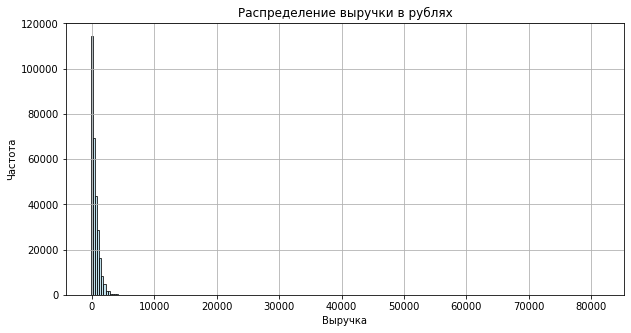

In [33]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
df['revenue_rub'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=250, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
                color = 'lightblue'
)

# Настраиваем оформление графика
plt.title('Распределение выручки в рублях')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

На графике видим ассимитричное распределение с правым хвостом, в которм присутстуют выбросы. Также видим, что большая часть значений расположена в диапозоне от 0 до 2000 руб.

Отфильтруем значения выручки в рублях по 99-у процентилю

In [34]:
# Находим 99-й процентиль
outliers = df['revenue_rub'].quantile(0.99)

In [35]:
# Создаем новый датафрейм с отфильтрованными значениями по 99-у процентилю
df = df.loc[df['revenue_rub'] < outliers]

In [36]:
# Проверяем
print(df['revenue_rub'].describe())

count    287604.000000
mean        516.693787
std         509.364868
min         -90.760002
25%         111.675001
50%         343.619995
75%         787.710022
max        2627.000000
Name: revenue_rub, dtype: float64


In [37]:
# Изучаем статистические показатели столбца tickets_count
print('Статистические показатели столбца tickets_count:')
df['tickets_count'].describe()

Статистические показатели столбца tickets_count:


count    287604.000000
mean          2.740330
std           1.163422
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

Среднее значение количества билетов практически совпадает с медианой, что говорит о симметричном распределении данных. Данные имеют небольшой разброс, что показывает значение стандартного отклонения 1,2, при среднем 2,3, разница между минимальным 1 и максимальным значением 57 показывает начилие выбросов в данных.

Посторим диаграмму размаха

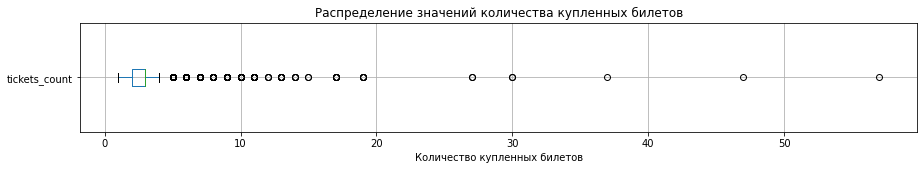

In [38]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 2))

# Строим диаграмму размаха значений в столбце seats
df.boxplot(column='tickets_count', vert=False) # Убираем пропущенные значения

# Добавляем заголовок и метки оси
plt.title('Распределение значений количества купленных билетов')
plt.xlabel('Количество купленных билетов')

# Выводим график
plt.show()

Данные имеют небольшое количество выбросов - это те заказы в которых куплено примерно от 8 до 15 билетов. И несколько аномальных значений заказы, в которых куплено более 20-и билетов.

In [39]:
# Проверим сколько удалено строк датасета
a, b = len(temp), len(df)
print(" Было строк в исходном датасете", a,
      '\n', "Осталось строк в датасете после обработки", b,
      '\n', "Удалено строк в датасете после обработки", a-b,
      '\n', "Процент потерь", round((a-b)/a*100, 2))

 Было строк в исходном датасете 290611 
 Осталось строк в датасете после обработки 287604 
 Удалено строк в датасете после обработки 3007 
 Процент потерь 1.03


На этапе предобработки данных мы загрузили датафрейм с информацией о курсе казахстанского тенге к рублю.
Привели в нем столбец `data` к формату даты для последующего соединения с основным датафреймом.
Соединили основной датафрейм с датафремом с курсом по полю даты используя `left` чтобы сохранить все строки основного датафрейма.
Создали функцию для конвертации выручки из тенге в рубли и используя метод `apply` применили функцию ко всем строкам датафрейма.

Также на этапе предобработки данных были проанализированы пропуски в датасете. Пропуски содержатся только в столбце `days_since_prev`, количество пропусков составляет 7,6%, что означает, что у 7.6% клиентов не было первого заказа.

У столбцов `revenue`,`days_since_prev`, `curs`, `revenue_rub` был оптимизирован тип данных с `float64` до `float32`.
У столбцов `tickets_count` и `nominal` был оптимизирован тип данных с `int64` до `int8`, а у столбцов `event_id` и `order_id` с `int64` до `int32`.

Проверили уникальные значение в категориальных столбцах на наличие значений-индикаторов пропусков или отсутствия данных. В стобце `event_type_main` есть значения с типом `другое`, что означает отсутствие информации о типе мероприятия. Однако мероприятий с таким типом слишком много - более 65 тыс. поэтому было решено не удалять эти строки, а анализировать как отдельную категорию.

Проверили данные на наличие явных дубликатов, до нормализации дубликатов не обраружено.
Провели нормализацию данных в текстовых столбцах, привели все к нижнему регистру и удалили пробелы.
Еще раз проверили данных на наличие явных дубликатов после нормализации данных, дубликатов не обнаружено. проверили наличие неявных дубликатов по столбцу `order_id`, дубликатов не обнаружено.

Изучили статистические показатели столбцов `revenue_rub` и `tickets_count`.
У столбца `revenue_rub` данные имеют большой разброс и правосторонний хвост. На гистограмме распределения данных `revenue_rub` присутствуют сильные выбросы. Отфильтровали данные в дататсете по 99-у перцентилю поля `revenue_rub`.
Данные столбца `tickets_count` имеют симметричное распределение и небольшое количество выбросов, что видно на диаграмме размаха.

Итого в датасете после предобработки данных осталось 287 604 строк, 3 007 было удалено, что составляет 1%. 
Добавлены новые поля с информацией о курсе тенге на день покупки билетов и основной столбец с выручкой в рублях.
`data` - дата курса,	`nominal` - номинал, `curs` - курс,	`cdx` - валюта,	`revenue_rub` - выручка в рублях.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [40]:
# Отсортировали данные по времени совершения заказа и сделали группировку
grouped_data = df.sort_values('order_ts').groupby('user_id', as_index=False).agg({
    'order_dt': ['min', 'max'],
    'order_id': 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
})


In [41]:
# Убрали многоуровневый индекс в названии столбцов
grouped_data.columns = ['user_id', 'min_order_dt', 'max_order_dt', 'order_count', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev']


In [42]:
# Добавим в датафрейм дату первого заказа у пользователя
df = df.merge(grouped_data, on='user_id', how='left')

In [43]:
# Отфильтровываем строки, с первым заказом у клиентов
grouped_data = df[(df['order_dt']==df['min_order_dt'])]

In [44]:
# Выводим нужные нам поля для профиля клиента
grouped_data = grouped_data[['user_id', 'min_order_dt', 'max_order_dt', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'order_count', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev']]

In [45]:
# Добавляем новый столбец с признаком наличия у клиента двух и более заказов
def cnt_orders(row):
    if row['order_count'] >= 2:
        return 1
    else:
        return 0

grouped_data['is_two'] = grouped_data.apply(cnt_orders, axis=1)

In [46]:
# Добавляем новый столбец с признаком наличия у клиента пяти и более заказов
def cnt_orders_five(row):
    if row['order_count'] >= 5:
        return 1
    else:
        return 0

grouped_data['is_five'] = grouped_data.apply(cnt_orders_five, axis=1)

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [47]:
# Считаем общее число пользователей в выборке
total_users = grouped_data['user_id'].count()
print(f'Общее число пользователей в выборке: {total_users}')

# Считаем среднюю выручку с одного заказа
# Сначала находим общую выручку
total_revenue = (grouped_data['avg_revenue_rub'] * grouped_data['order_count']).sum()

# И общее количество заказов 
total_orders = grouped_data['order_count'].sum()

# И находим среднюю выручку с одного заказа
avg_revenue = round(total_revenue / total_orders, 2)
print(f'Средняя выручка с одного заказа: {avg_revenue}')

# Считаем количество человек, совершившим 2 и более заказов
is_two_sum = grouped_data['is_two'].sum()

#Находим долю совершивших 2 и более заказа
is_two_d = round(is_two_sum / total_users, 4)* 100
print(f'Доля пользователей, совершивших 2 и более заказа: {is_two_d}%')

# Считаем количество человек, совершившим 5 и более заказов
is_five_sum = grouped_data['is_five'].sum()

#Находим долю совершивших 2 и более заказа
is_five_d = round(is_five_sum / total_users, 2) * 100
print(f'Доля пользователей, совершивших 5 и более заказов: {is_five_d}%')

Общее число пользователей в выборке: 34113
Средняя выручка с одного заказа: 490.21
Доля пользователей, совершивших 2 и более заказа: 75.48%
Доля пользователей, совершивших 5 и более заказов: 41.0%


Изучаем статистические показатели

In [48]:
grouped_data['order_count'].describe()

count    34113.000000
mean        46.416000
std        451.053829
min          1.000000
25%          2.000000
50%          3.000000
75%          9.000000
max      10175.000000
Name: order_count, dtype: float64

In [49]:
grouped_data['avg_tickets_count'].describe()

count    34113.000000
mean         2.735253
std          0.856515
min          1.000000
25%          2.028571
50%          2.700000
75%          3.060000
max         11.000000
Name: avg_tickets_count, dtype: float64

In [50]:
grouped_data['avg_days_since_prev'].describe()

count    25775.000000
mean        10.387514
std         18.003935
min          0.000000
25%          0.000000
50%          3.461539
75%         13.000000
max        148.000000
Name: avg_days_since_prev, dtype: float64

Данные содержат информацию о 34 113 пользователях, 75% из которых совершили 2 и более заказа. Данных достаточно для репрезентативности выборки.

Также в данных о количестве заказов обнаружены аномальные значения, которые искажают данные. 

В данных о среднем количестве билетов есть небольшой выброс, но он не влияет на среднее квадратическое отклонение, поэтому оставим их и учтем в анализе.



In [51]:
# Смотрим распределение данных о количестве заказов по квартилям, чтобы решить по какому квартирю делать фильтрацию
print(grouped_data['order_count'].describe(percentiles=[0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]))

count    34113.000000
mean        46.416000
std        451.053829
min          1.000000
25%          2.000000
50%          3.000000
60%          5.000000
70%          7.000000
75%          9.000000
80%         11.000000
85%         16.000000
90%         25.000000
95%         68.400000
98%        200.000000
99%        747.000000
max      10175.000000
Name: order_count, dtype: float64


Решили фильтровать по 95-у перцентилю, т.к 99 процентиль включает 747 заказов это фильтрация по нему не избавит данные от выбросов.

In [52]:
# Находим 95-й процентиль
outliers_group = grouped_data['order_count'].quantile(0.95)

In [53]:
# Создаем новый датафрейм с отфильтрованными значениями по 95-у процентилю
filter_data = grouped_data.loc[grouped_data['order_count'] < outliers_group]

In [54]:
# Проверим сколько удалено строк датасета
c, d = len(grouped_data), len(filter_data)
print(" Было строк в исходном датасете", c,
      '\n', "Осталось строк в датасете после обработки", d,
      '\n', "Удалено строк в датасете после обработки", c-d,
      '\n', "Процент потерь", round((c-d)/c*100, 2))

 Было строк в исходном датасете 34113 
 Осталось строк в датасете после обработки 32407 
 Удалено строк в датасете после обработки 1706 
 Процент потерь 5.0


Выводим статистические показатели по обновленному датасету


In [55]:
filter_data['order_count'].describe()

count    32407.000000
mean         6.648286
std          9.505026
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         68.000000
Name: order_count, dtype: float64

После фильтрации клиентов с большим количеством заказов, среднее количество заказов составило 7 шт и среднее квадратическое отклонение 10 шт. Теперь данные валидны и по ним можно проводить аналитику.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [56]:
# Группируем пользователей по типу их первого мероприятия и сразу скидываем индекс, чтобы результат был в датафрейме
group_event_type_main=filter_data.groupby('event_type_main', as_index=False)['user_id'].count().sort_values(by='user_id', ascending = False)

In [57]:
# Считаем общее количество клиентов
total = group_event_type_main['user_id'].sum()

In [58]:
# Добавляем столбец с процентами
group_event_type_main['perc']=round((group_event_type_main['user_id'] / total) * 100, 2)

In [59]:
group_event_type_main

,event_type_main,user_id,perc
2,концерты,14076,43.44
1,другое,7748,23.91
5,театр,6656,20.54
3,спорт,1615,4.98
4,стендап,1535,4.74
0,выставки,615,1.90
6,ёлки,162,0.50


In [60]:
# Группируем пользователей по типу их первого устройства с которого был сделан заказ
group_device_type_canonical=filter_data.groupby('device_type_canonical', as_index=False)['user_id'].count().sort_values(by='user_id', ascending = False)

In [61]:
# Добавляем столбец с процентами
group_device_type_canonical['perc']=round((group_device_type_canonical['user_id'] / total) * 100, 2)

In [62]:
group_device_type_canonical

,device_type_canonical,user_id,perc
1,mobile,26507,81.79
0,desktop,5900,18.21


In [63]:
# Группируем пользователей по региону проведения мероприятия из первого заказа
group_region_name=filter_data.groupby('region_name', as_index=False)['user_id'].count().sort_values(by='user_id', ascending = False)

In [64]:
# Добавляем столбец с процентами
group_region_name['perc']=round((group_region_name['user_id'] / total) * 100, 2)

In [65]:
group_region_name.head(5)

,region_name,user_id,perc
23,каменевский регион,10249,31.63
60,североярская область,5416,16.71
77,широковская область,1865,5.75
45,озернинский край,992,3.06
42,медовская область,940,2.90


In [66]:
# Группируем пользователей по билетному оператору из первого заказа
group_service_name=filter_data.groupby('service_name', as_index=False)['user_id'].count().sort_values(by='user_id', ascending = False)

In [67]:
# Добавляем столбец с процентами
group_service_name['perc']=round((group_service_name['user_id'] / total) * 100, 2)

In [68]:
group_service_name.head(5)

,service_name,user_id,perc
3,билеты без проблем,7325,22.60
22,мой билет,4476,13.81
19,лови билет!,4378,13.51
4,билеты в руки,4162,12.84
23,облачко,2998,9.25


Пользователи распределены по сегментам неравномерно. Самыми крупными точками входа являются концерты - 43% пользователей совершили первый заказ покупая билет на концерт. 82% совершили свой первый заказ с мобильного телефона. 32% пользователей совершили свой первый заказ в каменевском регионе и 23% пользователей сделали свой первый заказ через оператора билеты без проблем. Это сегменты с наибольшим количеством пользователей по первому заказу.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [69]:
# Добавляем группировку по пользователям, которые совершили два и более заказа
group_is_two=filter_data.groupby('event_type_main', as_index=False)['is_two'].sum().sort_values(by='is_two', ascending = False)

In [70]:
# Соединяем две группировки в одну табличку
group_event_type_main = group_event_type_main.merge(group_is_two, on='event_type_main', how='left')

In [71]:

group_event_type_main['is_two_perc']=round((group_event_type_main['is_two'] / group_event_type_main['user_id']) * 100, 2)

In [72]:
group_event_type_main

,event_type_main,user_id,perc,is_two,is_two_perc
0,концерты,14076,43.44,10430,74.10
1,другое,7748,23.91,5557,71.72
2,театр,6656,20.54,5104,76.68
3,спорт,1615,4.98,1264,78.27
4,стендап,1535,4.74,1101,71.73
5,выставки,615,1.90,466,75.77
6,ёлки,162,0.50,120,74.07


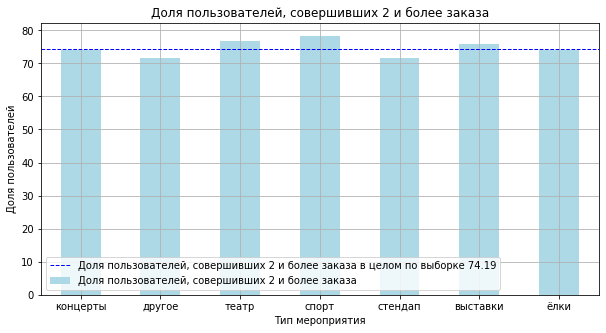

In [73]:
# Строим график столбчатой диаграммы

group_event_type_main.plot(
               x='event_type_main',
               y = 'is_two_perc',
               kind='bar',
               title=f'Доля пользователей, совершивших 2 и более заказа',
               legend=True,
               ylabel='Доля пользователей',
               xlabel='Тип мероприятия',
               rot=0,
               figsize=(10, 5),
               color = 'lightblue',
               label='Доля пользователей, совершивших 2 и более заказа')


# Рассчитываем среднее значение клиентов, совершивших 2 и более заказа
mean_is_two = filter_data['is_two'].mean()

# Наносим на график линию с средним значением  клиентов, совершивших 2 и более заказа
plt.axhline(mean_is_two*100, # Данные, по которым строится линия
            color='blue', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Доля пользователей, совершивших 2 и более заказа в целом по выборке {round(mean_is_two*100,2)}')

plt.grid()
plt.legend()
# Выводим график
plt.show()

Не смотря на то, что больше всего клиентов пришли через канал `концерты`, у таких клиентов процент возврата меньше, чем в целом по выборке.

Чаще возвращаются клиенты, которые купили первые билеты на мероприятия категории `спорт` - 78,3%. Также к успешным точкам входа можно отнести `театр` с процентом повторной покупки - 76,7%, клиенты, которые пришли через эти каналы возвращаются чаще среднего значения совершения клиентам повторной покупки - 74,2%.


Вычисляем долю пользователей, совершивших два и более заказа для сегментов по типу устройств

In [74]:
# Добавляем группировку по пользователям, которые совершили два и более заказа
group_is_two_device=filter_data.groupby('device_type_canonical', as_index=False)['is_two'].sum().sort_values(by='is_two', ascending = False)

In [75]:
# Соединяем две группировки в одну табличку
group_device_type_canonical = group_device_type_canonical.merge(group_is_two_device, on='device_type_canonical', how='left')

In [76]:
group_device_type_canonical['is_two_perc']=round((group_device_type_canonical['is_two'] / group_device_type_canonical['user_id']) * 100, 2)

In [77]:
group_device_type_canonical

,device_type_canonical,user_id,perc,is_two,is_two_perc
0,mobile,26507,81.79,19483,73.50
1,desktop,5900,18.21,4559,77.27


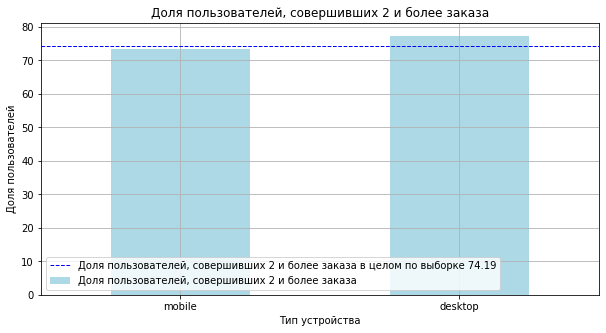

In [78]:
# Строим график столбчатой диаграммы

group_device_type_canonical.plot(
               x='device_type_canonical',
               y = 'is_two_perc',
               kind='bar',
               title=f'Доля пользователей, совершивших 2 и более заказа',
               legend=True,
               ylabel='Доля пользователей',
               xlabel='Тип устройства',
               rot=0,
               figsize=(10, 5),
               color = 'lightblue',
               label='Доля пользователей, совершивших 2 и более заказа')


# Рассчитываем среднее значение клиентов, совершивших 2 и более заказа
mean_is_two = filter_data['is_two'].mean()

# Наносим на график линию с средним значением  клиентов, совершивших 2 и более заказа
plt.axhline(mean_is_two*100, # Данные, по которым строится линия
            color='blue', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Доля пользователей, совершивших 2 и более заказа в целом по выборке {round(mean_is_two*100,2)}')

plt.grid()
plt.legend()
# Выводим график
plt.show()

Пользователи, которые оформили свой первый заказ со стационарного устройста составляют 20% от общего количества пользователей, но они чаще возвращаются в Яндекс Афишу (77,3% совершили повторный заказ), чем пользователи, которые оформили свой первый заказ через мобильное приложение.

Вычисляем долю пользователей, совершивших два и более заказа для сегментов по региону проведения мероприятия.

In [79]:
# Добавляем группировку по пользователям, которые совершили два и более заказа
group_is_two_region=filter_data.groupby('region_name', as_index=False)['is_two'].sum().sort_values(by='is_two', ascending = False)

In [80]:
# Соединяем две группировки в одну табличку
group_region_name = group_region_name.merge(group_is_two_region, on='region_name', how='left')

In [81]:
group_region_name['is_two_perc']=round((group_region_name['is_two'] / group_region_name['user_id']) * 100, 2)

In [82]:
# Убираем те регионы, где меньше 100 клиентов и оставляем только топ-10 по количеству клиентов регионов
group_region_name = group_region_name[(group_region_name['user_id']>100)].sort_values('user_id', ascending = False).head(10)

In [83]:
group_region_name

,region_name,user_id,perc,is_two,is_two_perc
0,каменевский регион,10249,31.63,7585,74.01
1,североярская область,5416,16.71,4053,74.83
2,широковская область,1865,5.75,1431,76.73
3,озернинский край,992,3.06,690,69.56
4,медовская область,940,2.90,788,83.83
5,шанырский регион,862,2.66,698,80.97
6,малиновоярский округ,780,2.41,549,70.38
7,светополянский округ,719,2.22,562,78.16
8,травяная область,683,2.11,495,72.47
9,речиновская область,681,2.10,520,76.36


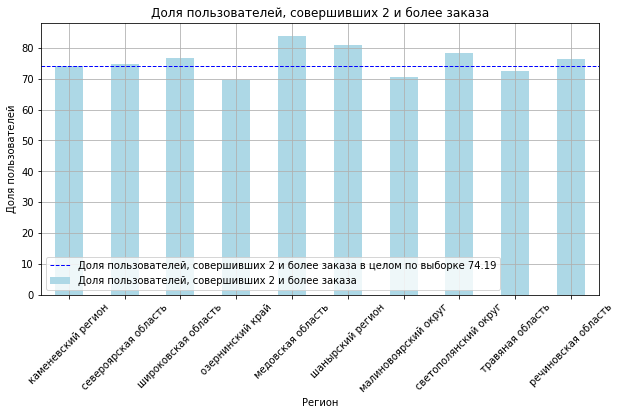

In [84]:
# Строим график столбчатой диаграммы

group_region_name.plot(
               x='region_name',
               y = 'is_two_perc',
               kind='bar',
               title=f'Доля пользователей, совершивших 2 и более заказа',
               legend=True,
               ylabel='Доля пользователей',
               xlabel='Регион',
               rot=45,
               figsize=(10, 5),
               color = 'lightblue',
               label='Доля пользователей, совершивших 2 и более заказа')


# Рассчитываем среднее значение клиентов, совершивших 2 и более заказа
mean_is_two = filter_data['is_two'].mean()

# Наносим на график линию с средним значением  клиентов, совершивших 2 и более заказа
plt.axhline(mean_is_two*100, # Данные, по которым строится линия
            color='blue', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Доля пользователей, совершивших 2 и более заказа в целом по выборке {round(mean_is_two*100,2)}')

plt.grid()
plt.legend(loc='lower left')

# Выводим график
plt.show()

Чаще возвращаются в Яндекс Афишу пользователи, которые совершили свой первый заказ в `медовской области` - 84% пользователей совершили повторный заказ. К наиболее успешным точкам входа можно отнести `шанырский регион` - 81%, `светополянский округ`-78%, `широковская область`, `речиновскую область`и `североярскую область` в этих регионах пользователи возвращаюся за повторной покупкой чаще, чем в среднем.

Вычисляем долю пользователей, совершивших два и более заказа для сегментов по билетному оператору.

In [85]:
# Добавляем группировку по пользователям, которые совершили два и более заказа
group_is_two_service=filter_data.groupby('service_name', as_index=False)['is_two'].sum().sort_values(by='is_two', ascending = False)

In [86]:
# Соединяем две группировки в одну табличку
group_service_name = group_service_name.merge(group_is_two_service, on='service_name', how='left')

In [87]:
group_service_name['is_two_perc']=round((group_service_name['is_two'] / group_service_name['user_id']) * 100, 2)

In [88]:
# Убираем тех операторов, которые продали билеты меньше чем 100 клиентам и оставляем только топ-10 по количеству клиентов 
group_service_name = group_service_name[(group_service_name['user_id']>100)].sort_values('user_id', ascending = False).head(10)

In [89]:
group_service_name

,service_name,user_id,perc,is_two,is_two_perc
0,билеты без проблем,7325,22.60,5272,71.97
1,мой билет,4476,13.81,3317,74.11
2,лови билет!,4378,13.51,3280,74.92
3,билеты в руки,4162,12.84,3208,77.08
4,облачко,2998,9.25,2155,71.88
5,весь в билетах,1869,5.77,1392,74.48
6,лучшие билеты,1854,5.72,1395,75.24
7,прачечная,1035,3.19,817,78.94
8,край билетов,700,2.16,542,77.43
9,дом культуры,552,1.70,426,77.17


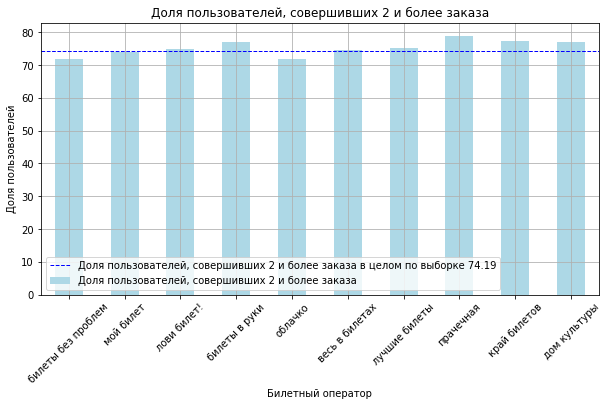

In [90]:
# Строим график столбчатой диаграммы

group_service_name.plot(
               x='service_name',
               y = 'is_two_perc',
               kind='bar',
               title=f'Доля пользователей, совершивших 2 и более заказа',
               legend=True,
               ylabel='Доля пользователей',
               xlabel='Билетный оператор',
               rot=45,
               figsize=(10, 5),
               color = 'lightblue',
               label='Доля пользователей, совершивших 2 и более заказа')


# Рассчитываем среднее значение клиентов, совершивших 2 и более заказа
mean_is_two = filter_data['is_two'].mean()

# Наносим на график линию с средним значением  клиентов, совершивших 2 и более заказа
plt.axhline(mean_is_two*100, # Данные, по которым строится линия
            color='blue', # Цвет линии
            linestyle='--', # Стиль линии
            linewidth=1, # Ширина линии
            label=f'Доля пользователей, совершивших 2 и более заказа в целом по выборке {round(mean_is_two*100,2)}')

plt.grid()
plt.legend(loc='lower left')

# Выводим график
plt.show()

Чаще всего в Яндекс Афишу возвращаются пользователи, которые сделали свой первый заказ у билетного оператора `прачечная` - 79%. Также к успешным точкам входа можно отнести билетных операторов `край билетов`,  `дом культуры` и `билеты в руки` у которых доля возврата пользователей больше, чем среднняя - 77%.

Самыми не успешеыми по возврату пользователей операторами явлются `облачко` и `билеты без проблем` у которых процент возврата составил 72%.

Таким образом, наиболее велика вероятность возврата клиента, который совершил свой первый заказ покупая билеты на спортивное мероприятие со стационарного устройста в медовской области у билетного оператора прачечная.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Проверим продуктовую Гипотезу 1. "Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты."

In [91]:
group_event_type_main

,event_type_main,user_id,perc,is_two,is_two_perc
0,концерты,14076,43.44,10430,74.10
1,другое,7748,23.91,5557,71.72
2,театр,6656,20.54,5104,76.68
3,спорт,1615,4.98,1264,78.27
4,стендап,1535,4.74,1101,71.73
5,выставки,615,1.90,466,75.77
6,ёлки,162,0.50,120,74.07


78% пользователей, совершивших первый заказ на спортивные мероприятия, совершают повторный заказ, в то время как из пользователей, оформивших свой первый заказ на концерты повторно возвращаются в Яндекс Афишу 74%. Из этого можно подтвердить Гипотезу 1 и сделать вывод, что тип мероприятия влияет на вероятность возврата пользователя.

Проверим продуктовую Гипотезу 2. "В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах."

In [92]:
group_region_name

,region_name,user_id,perc,is_two,is_two_perc
0,каменевский регион,10249,31.63,7585,74.01
1,североярская область,5416,16.71,4053,74.83
2,широковская область,1865,5.75,1431,76.73
3,озернинский край,992,3.06,690,69.56
4,медовская область,940,2.90,788,83.83
5,шанырский регион,862,2.66,698,80.97
6,малиновоярский округ,780,2.41,549,70.38
7,светополянский округ,719,2.22,562,78.16
8,травяная область,683,2.11,495,72.47
9,речиновская область,681,2.10,520,76.36


Исходя из проведенного анализа по регионам, мы видим что больше всего пользователей совершили своей первый заказ в каменевском регионе, североярской области и широковской области, но для повторных покупок в данных регионах ниже, чем в менее активных  регионах. Например, в каменевском регионе доля пользователей совершивших 2 и более заказа 74%, а в медовской области 84%, что не подтверждает Гипотезу 2 о том, что в регионах, где больше пользователей посещают мероприятия выше вероятность возврата.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [93]:
filter_data['avg_revenue_rub'].describe()

count    32407.000000
mean       539.070618
std        428.673950
min        -10.770000
25%        197.618423
50%        458.702454
75%        774.693329
max       2624.814697
Name: avg_revenue_rub, dtype: float64

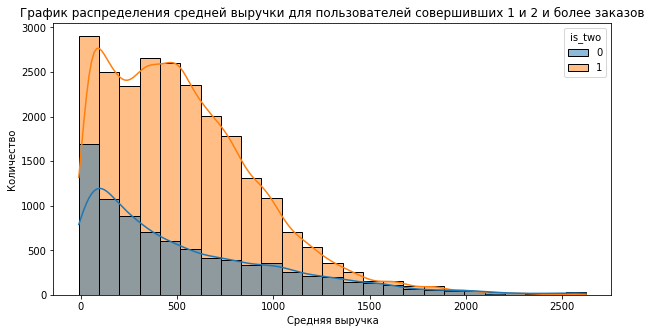

In [94]:
plt.figure(figsize=(10, 5))
sns.histplot(data = filter_data,
             x = 'avg_revenue_rub',
             kde = True,
             hue = 'is_two',
             bins=25,
             alpha=0.5
            ) 


plt.title('График распределения средней выручки для пользователей совершивших 1 и 2 и более заказов')
plt.ylabel('Количество')
plt.xlabel('Средняя выручка')
plt.show()

Пользователи из обоих групп концентрируются в диапазоне выручки от 0 до 500 руб, но больше всего пользователей сконцентрировано в дипазоне от 0 до 100 руб., большую часть из которых занимают пользователи с 1 заказом. 

По графику видно, что  пользователей совершивших 2 и более заказа в 2 раза больше, чем пользователей совершивших 1 заказ. Также у пользователей совершивших 2 и более заказа средняя выручка значительно больше, чем пользователей совершивших 1 заказ.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [95]:
# Отфильтруем датафрейм, для сравнения оставим только тех клиентов у которых 2 и более заказов
filter_revenue_df = filter_data[(filter_data['is_two']==1)]


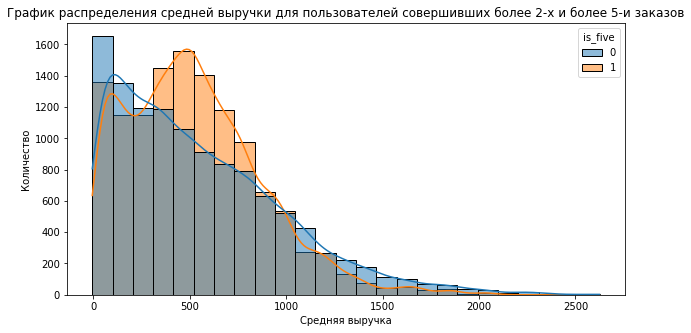

In [96]:
plt.figure(figsize=(10, 5))
sns.histplot(data = filter_revenue_df,
             x = 'avg_revenue_rub',
             kde = True,
             hue = 'is_five',
             bins=25,
             alpha=0.5
            ) 


plt.title('График распределения средней выручки для пользователей совершивших более 2-х и более 5-и заказов')
plt.ylabel('Количество')
plt.xlabel('Средняя выручка')
plt.show()

Пользователи совершившие 2-4 заказа чаще всего имеют небольшую среднюю выручку от 0 до 100 руб., в то время как пользователи совершившие более 5-и заказов чаще всего имеют среднюю выручку 400-500 рублей.

Получается, что пользователи совершившие 5 и более заказов приносят больше выручки с заказа. При этом, можно заметить, что в правом хвосте графика преобладают клиенты сделавшие менее пяти заказов, что говорит о том, что некоторые клиенты делают крупные, но не такие частые заказы.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [97]:
filter_data['avg_tickets_count'].describe()

count    32407.000000
mean         2.736035
std          0.875863
min          1.000000
25%          2.000000
50%          2.700000
75%          3.142857
max         11.000000
Name: avg_tickets_count, dtype: float64

Среднее значение количества билетов совпадает с медианой, что говорит о симметричном распределении данных. Данные имеют небольшой разброс, что показывает значение стандартного отклонения 0,9, при среднем 2,7, разница между минимальным 1 и максимальным значением 11 показывает начилие небольшого количества выбросов в данных.


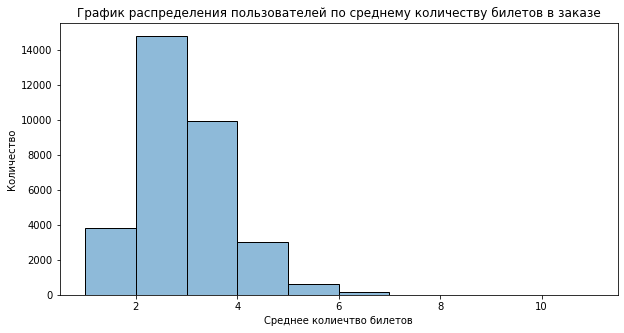

In [98]:
plt.figure(figsize=(10, 5))
sns.histplot(data = filter_data,
             x = 'avg_tickets_count',
             bins=10,
             alpha=0.5
            ) 


plt.title('График распределения пользователей по среднему количеству билетов в заказе')
plt.ylabel('Количество')
plt.xlabel('Среднее колиечтво билетов')
plt.show()

Большинство пользователей более 14000 покупают в среднем более от 2 до 3-х билетов в заказе. Около 10000 клиентов покупают от 3 до 4 билетов. Меньше всего в среднем покупают от 6 до 7 билетов. Значения от 7 до 11 билетов являются выбросами.

In [99]:
# Добавим столбец с сегментами пользователей по количеству билетов.
def cat_ticket(row):
    if row['avg_tickets_count'] >= 1 and row['avg_tickets_count'] < 2:
        return 'от 1 до 2 билетов'
    elif row['avg_tickets_count'] >= 2 and row['avg_tickets_count'] < 3:
        return 'от 2 до 3 билетов'
    elif row['avg_tickets_count'] >= 3 and row['avg_tickets_count'] < 5:
        return 'от 3 до 5 билетов'
    else:
        return 'от 5 и более билетов'

filter_data['category'] = filter_data.copy().apply(cat_ticket, axis=1)

/tmp/ipykernel_72/1005001838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['category'] = filter_data.copy().apply(cat_ticket, axis=1)


In [100]:
# Считаем общее число пользователей для каждого сегмента
group_category=filter_data.groupby(['category'], as_index=False)['user_id'].count().sort_values(by='user_id', ascending = False)

In [101]:
# Считаем долю пользователей для каждого сегмента
group_category['prc']=round(group_category['user_id'] / total * 100, 2)

In [102]:
group_category

,category,user_id,prc
1,от 2 до 3 билетов,14805,45.68
2,от 3 до 5 билетов,12978,40.05
0,от 1 до 2 билетов,3821,11.79
3,от 5 и более билетов,803,2.48


In [103]:
# В датафрейм, где отфильтрованы только пользователи совершившие 2 и более заказа добавляем категорию
filter_revenue_df['category'] = filter_revenue_df.copy().apply(cat_ticket, axis=1)

/tmp/ipykernel_72/2673708254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_revenue_df['category'] = filter_revenue_df.copy().apply(cat_ticket, axis=1)


In [104]:
# Теперь группируем этот датарфрейм
group_two_orders = filter_revenue_df.groupby(['category'], as_index=False)['user_id'].count().sort_values(by='user_id', ascending = False)

In [105]:
# Соединяем две группировки в одну табличку
group_category = group_category.merge(group_two_orders, on='category', how='left')

In [106]:
# Считаем долю пользователей совершивших повторные заказы
group_category['prc_two']=round(group_category['user_id_y'] / group_category['user_id_x'] * 100, 2)


In [107]:
group_category

,category,user_id_x,prc,user_id_y,prc_two
0,от 2 до 3 билетов,14805,45.68,12295,83.05
1,от 3 до 5 билетов,12978,40.05,8838,68.10
2,от 1 до 2 билетов,3821,11.79,2643,69.17
3,от 5 и более билетов,803,2.48,266,33.13


Пользователи распределены по сегметам неравномерно, они сконцентрированы в первых двух сегментах `от 2 до 3 билетов` и `от 3 до 5`, на эти две категории приходится по 46% и 40% соответственно. Меньше всего пользователей - 2% находится в категории `от 5 и более билетов`.

Не смотря на то, что процент пользователей в сегментах `от 2 до 3 билетов` и `от 3 до 5` практический одинаковый, доля повторных покупок у них разная. У сегмента `от 2 до 3 билетов` доля повторных покупок составляет 83%, а у сегмента `от 3 до 5` 68%.
Можно обратить внимание на то, что на сегмент  `от 5 и более билетов` приходится всего 2% пользователей и у них 33% доля повторных покупок, что может говорить о том, что клиенты делающие заказы с большим количеством билетов больше разовые, чем постоянные.


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [108]:
#Добавим в профиль клиента столбец с названием и номером дня недели первого заказа
filter_data['day_name'] = filter_data['min_order_dt'].copy().dt.day_name()
filter_data['day_of_week'] = filter_data['min_order_dt'].copy().dt.day_of_week

/tmp/ipykernel_72/3060255583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['day_name'] = filter_data['min_order_dt'].copy().dt.day_name()
/tmp/ipykernel_72/3060255583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['day_of_week'] = filter_data['min_order_dt'].copy().dt.day_of_week


In [109]:
# Считаем общее число пользователей для дня недели
group_day_name=filter_data.groupby(['day_name', 'day_of_week'], as_index=False)['user_id'].count().sort_values(by='day_of_week')

In [110]:
# В датафрейм, где отфильтрованы только пользователи совершившие 2 и более заказа столбец с названием и номером дня недели первого заказа
filter_revenue_df['day_name'] = filter_revenue_df['min_order_dt'].copy().dt.day_name()
filter_revenue_df['day_of_week'] = filter_revenue_df['min_order_dt'].copy().dt.day_of_week

/tmp/ipykernel_72/3987718734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_revenue_df['day_name'] = filter_revenue_df['min_order_dt'].copy().dt.day_name()
/tmp/ipykernel_72/3987718734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_revenue_df['day_of_week'] = filter_revenue_df['min_order_dt'].copy().dt.day_of_week


In [111]:
# Теперь группируем этот датарфрейм
group_day_name_two_orders = filter_revenue_df.groupby(['day_name', 'day_of_week'], as_index=False)['user_id'].count().sort_values(by='day_of_week')

In [112]:
# Соединяем две группировки в одну табличку
group_day_name = group_day_name.merge(group_day_name_two_orders, on='day_name', how='left')

In [113]:
# Считаем долю пользователей совершивших повторные заказы
group_day_name['prc_two']=round(group_day_name['user_id_y'] / group_day_name['user_id_x'] * 100, 2)


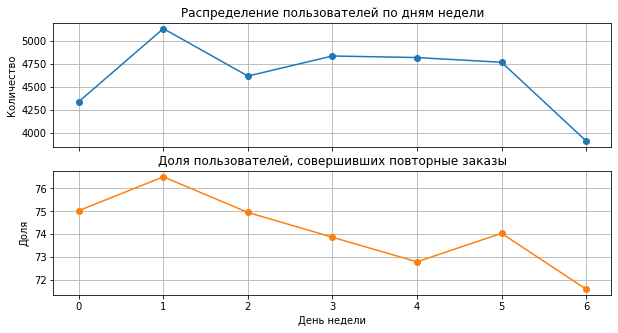

In [114]:
# Строим график
a = group_day_name.plot.line(
    x='day_of_week_x',
    subplots=True,
    sharex=True,
    sharey=False,
    legend=False,
    y=['user_id_x', 'prc_two'],
    figsize=(10, 5),
    marker='o',
    title = ['Распределение пользователей по дням недели', 'Доля пользователей, совершивших повторные заказы'])

# Устанавливаем подпись для оси Y каждого из подграфиков
a[0].set_ylabel('Количество')
a[1].set_ylabel('Доля')

# Включаем сетку для каждого из подграфиков
a[0].grid(which='both')
a[1].grid(which='both')

# Подписываем ось X
plt.xlabel('День недели')
plt.show()

In [115]:
group_day_name

,day_name,day_of_week_x,user_id_x,day_of_week_y,user_id_y,prc_two
0,Monday,0,4337,0,3254,75.03
1,Tuesday,1,5131,1,3925,76.50
2,Wednesday,2,4615,2,3459,74.95
3,Thursday,3,4833,3,3570,73.87
4,Friday,4,4816,4,3506,72.80
5,Saturday,5,4765,5,3528,74.04
6,Sunday,6,3910,6,2800,71.61


Те кто совержил первый заказ в воскресенье, возвращаются реже всего - 71,6%, а те кто совершил первый заказ во вторник - чаще всего - 76,5%. Пользователи, совершившие первый заказ в середине недели в четверг и пятницу растут, но процент возвратов таких клиентов падает. 

Получается, что начало недели - самые эффективные дни для входа клиента и ближе к концу недели снижается вероятность повторной покупки. День недели, в который совершена первая покупка влияет на вероятность возврата клиента. 

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [116]:
# Используем ранее отфильтрованный датайфрейм, в которым только клиенты совершившие 2 и более заказов
# Делаем группировку по признаку сделал клиент 5 и более заказов
filter_revenue_df.groupby(['is_five'], as_index=False)['avg_days_since_prev'].mean()

,is_five,avg_days_since_prev
0,0,14.430905
1,1,7.837327


У клиентов, которые совершили 5 и более заказов среднее время между заказами составляет 8 дней, что в 2 раза меньше чем уклиентов, которые совершили 2-4 заказа. Значит можно сделать вывод, что чем меньше средний интервал между заказами, тем больше вероятность повторного заказа.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [117]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = filter_data[['device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'order_count',
                                   'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev', 'is_two', 'is_five',
                                   'category', 'day_name', 'day_of_week']].phik_matrix(interval_cols=['order_count', 
                                    'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev'])

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной order_count')
correlation_matrix.loc[correlation_matrix.index != 'order_count'][['order_count']].sort_values(by='order_count', ascending=False)

Корреляционная матрица с коэффициентом phi_k для переменной order_count


,order_count
is_five,0.887887
is_two,0.435425
avg_days_since_prev,0.311262
region_name,0.288903
avg_tickets_count,0.253333
avg_revenue_rub,0.211226
category,0.209430
service_name,0.180570
event_type_main,0.138643
device_type_canonical,0.106135


In [118]:
# Добавим столбец с сегментами пользователей по количеству заказов.
def cat_orders(row):
    if row['order_count'] == 1:
        return '1 заказ'
    elif row['order_count'] >= 2 and row['order_count'] <= 4:
        return 'от 2 до 4 заказов'
    else:
        return 'от 5 и выше'

filter_data['category_orders'] = filter_data.copy().apply(cat_orders, axis=1)

/tmp/ipykernel_72/3527868883.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['category_orders'] = filter_data.copy().apply(cat_orders, axis=1)


In [119]:
# Вычисляем корреляционную матрицу с использованием phi_k
correlation_matrix = filter_data[['device_type_canonical', 'region_name', 'service_name', 'event_type_main', 'category_orders',
                                   'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev', 'is_two', 'is_five',
                                   'category', 'day_name', 'day_of_week']].phik_matrix(interval_cols=[ 
                                    'avg_revenue_rub', 'avg_tickets_count', 'avg_days_since_prev'])

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной category_orders')
correlation_matrix.loc[correlation_matrix.index != 'category_orders'][['category_orders']].sort_values(by='category_orders', ascending=False)

Корреляционная матрица с коэффициентом phi_k для переменной category_orders


,category_orders
is_two,1.000000
is_five,1.000000
avg_tickets_count,0.349846
avg_days_since_prev,0.342171
avg_revenue_rub,0.244122
region_name,0.202250
category,0.195284
service_name,0.139276
event_type_main,0.074261
day_name,0.064878


Сильная связь у количества заказов клиента с признаками по количеству заказов клиента, что логично. 

Далее больше всего с количеством заказов у клиента связан показатель среднего количества билетов в заказе 35%, однако связь не очень сильная.

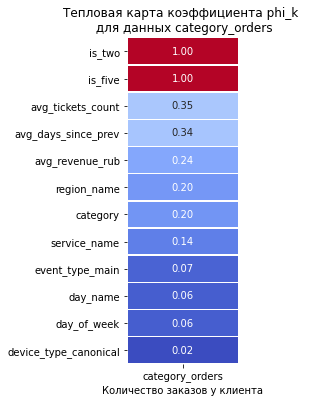

In [120]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака количества заказов с другими признаками клиента
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'category_orders'][['category_orders']].sort_values(by='category_orders', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных category_orders')
plt.xlabel('Количество заказов у клиента')

# Выводим график
plt.show()

В результате получаем, что помимо очевидых признаков, с количеством заказов больше всего связаны среднее количество билетов в заказе, среднее количество дней между заказами, средняя выручка и регион, но связь не сильная.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.


#### Общий обзор проделанной работы.

В ходе проведения исследования нами был получен доступ к базе данных Яндекс Афиши, содержащей 4 таблицы с информацией 
о заказах клиентов.

- Был подготовлен SQL запрос для сбора единой витрины, далее было настроено подключение и произведена выгрузка данных в датафрейм.  
- Проанализировали содержимое данных, данные содержат информацию о 290 611 заказах клиентов в Яндекс Афише, 
в том числе информацию о количетсве купленных билетов, типе мероприятия, регионе и выручке.
- Был проведен анализ соответствия значений столбцов их содержимому.
- Названия столбцов были переданы в формате snake case.
- Перевели выручку в рубли, загрузили для этого дополнительный датафрейм с курсом казахстанского тенге к рублю.
В резултате был создан новый столбец с выручкой в рублях.
- Проанализировали наличие пропусков в данных. Пропуски были обнаружены только в столбце `days_since_prev`, что является 
нормой, т.к. есть клиенты у которых не было первого заказа. Было принято решение сохранить для анализа данные пропуски.
- Были проанализированы типы данных и проведено понижение размерности типов данных в необходимых столбцах 
`revenue`, `days_since_prev`, `curs`, `revenue_rub`, `tickets_count`,`event_id`, `order_id`, `nominal`.
- Проверили уникальные значения в категориальных столбцах на предмет наличия значений индикаторов означающих пропуски 
или отсутствие информации. В результате в стобце `event_type_main` было найдено значение `другое`, что означает отсутствие информации о типе мероприятия.
но было принято решение оставить данные значение для анализа, т.к. мероприятий с типо другое слишком много - более 65 тыс.
 строк и их удаление может исказить рещультаты анализа.
- Далее были нормализованы значения данных в текстовых столбцах.
- Проверили наличие явных и неявных дубликатов, дубликатов не найдено.
- Изучили распределение численных данных на наличие в них выбросов. В столбце `revenue_rub` - выручка в рублях было 
выявлено большое количество аномальных выбросов, которые искажали данные. Было принято решение их отфильтровать по 99-у процентилю для 
дальнейшего анализа. В результате фильтрации было удалено 3 007 строк - 1,03% данных. 


#### Основные результаты анализа.


Для дальнейшего анализа зависисмости возврата клиента от показателей его первого заказа мы подготовили датафрейм "Профиль клиента" с агрегированными показателями по первому заказу каждого клиента. В датафрейм добавили признаки, совершения клиентом 2-х и более заказов или 5-и более заказов.

**Проанализировали полученный профиль клиента** и изучили репрезентативность данных:
- Всего в выборе 34 113 пользователей.
- Среднее количество билетов в заказе 2,7 билета.
- Среднее количество дней между покупками 10,4 дня.
- Средняя выручка с одного заказа составляет: 490.2 руб.
- Доля пользователей, совершивших 2 и более заказа: 75.5%
- Доля пользователей, совершивших 5 и более заказов: 41.0%

Показатель среднего количества заказов в "Профиле клиента" имел большое количество аномальных выбросов, поэтому было принято решение отфильтровать его по 95-у перцентилю. В результате фильтрации было удалено 1 706 строк и в итоговом датафрейме осталось 32 407 клиентов.

- Среднее количество заказов на клиента составило 6,6 заказов.




**Проанализировали как распределены клиенты по показателям профиля клиента. И в каких сегментах клиенты чаще возвращаются для повторного заказа**

Наиболее яркие признаки клиента Яндекс Афишы:

- 43% пользователей своершили свой первый заказ покупая билет на концерт, но повторно
возращаются из них 74%. Чаще всего возращаются клиенты, купившие первый билет на
спортивные мероприятия - 78% повторных заказов. Еще можно выделить клиентов, купивших
билет в театр у них тоже большой процент возврата - 76%.

- 82% совершили своей первый заказ с мобильного телефона, но повторно возвращаются из 
них 74%. Чаще возвращаются клиенты, совершившие свой первый заказ со стационарного
устройства - 77%. 

- 32% пользователей совершили свой первый заказ в каменевском регионе, но повторно
возращаются из них 74%. Чаще всего возращаются клиенты, купившие первый билет в 
медовской области - 84%. Еще можно выделить клиентов, сделавших свой первый 
заказ в шанырском регионе у них тоже большой процент возврата - 81%.

- 23% пользователей сделали свой первый заказ через оператора билеты без проблем. 
Однако по проценту возвратов пользователей это самый неудачный билетный оператор.
Лидирующим по проценту возвратов является оператор прачечная - 79%.

Таким образом, пользователи распределены по признакам неравномерно и есть наиболее яркие
точки входа клиента в Яндекс Афишу. И данные точки не являются точками с самым высоким 
процентов повторных покупок.

К самым крупным точкам входа относятся клиенты купившие свой первый билет на концерт, через 
мобильный телефон, в каменевском регионе у оператора билеты без проблем.
А к самым успешным клиенты купившие свой первый билет на спортивные мероприятия, со 
стационарного устройства, в медовской области у оператора прачечная.

В результате анализа профиля клиента была подтверждена Гипотеза 1.
"Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые 
совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем 
пользователи, оформившие свой первый заказ на концерты."

и опровергнута Гипотеза 2.
"В регионах, где больше всего пользователей посещают мероприятия, выше 
доля повторных заказов, чем в менее активных регионах."


**Проанализировали взаимосвязь выручки и повторных заказов.**

У клиентов с 1 заказом средняя выручка меньше, чем у клиентов с повторными заказами.
Из клиентов с повторными заказами, у клиентов с 2-4 заказами средняя выручка чаще попадает в интервал от 0 до 100 руб., в то время как пользователи совершившие более 5-и заказов чаще всего имеют среднюю выручку 400-500 рублей.

Получается, что пользователи совершившие 5 и более заказов приносят больше выручки с заказа. При этом, стоит заметить, что некоторые клиенты делают крупные, но не такие частые заказы.

Можно сделать вывод, что средняя выручка связана с верояностью повторных покупок. Но не очевидно что является причиной, а что следствием.

**Проанализировали взаимосвязь среднего количества билетов в заказе и повторных заказов.**

Изучили распределение среднего значения билетов в заказе. Данные имеют симметричное распределение с небольшим количеством выбросов.
Добавили столбец с распределением пользователей по количеству билетов в заказе.
Больше всего пользователей покупает от 2 до 3 билетов - 46% доля повторных покупок у этих клиентов 83%, что значительно выше чем в остальных сегментах.

Пользователи покупающие 2-3 билета чаще остальных возвращаются за повторными покупками.

**Проанализировали взаимосвязь временных характеристик первого заказа клиента и повторых заказов.**

Больше всего пользователей делают заказ во вторник и 77% из них возвращаются за повторными покупками. Ближе к концу недели процент повторных покупок 
снижается. Из пользователей, совершивших первый заказ в воскресенье, возвращаются всего - 72%

Чем меньше средний интервал между заказами у пользователей, тем больше повторных покупок они совершают. У пользователей с 5 и более заказами интервал между 
покупками в 2 раза меньше, чем у остальных.

**По данным корреляционного анализа** больше всего с количеством заказов связаны среднее количество билетов в заказе, 
среднее количество дней между заказами, средняя выручка и регион, но связь не сильная. И меньше всего связаны тип устройства и день недели.

#### **Рекомендации**

- Так как с количеством заказов больше всего связано среднее количество билетов в заказе,
то стоит обратить внимание на сегмент, в котором среднее количество билетов максимальное.
Больше всего клиентов покупают от 2 до 3 билетов - 46% всех клиентов и от 3 до 5 билетов 
40%. Но процент возврата клиентов, покупающих от 2 до 3 билетов составляет 83%.
А процент возврата клиентов, покупающих от 3 до 5 билетов - 68%. Возможно это клиенты
с большими семьями и детьми и им можно предложить скидку на следующую покупку для
увеличения доли возвратов.
- Стоит обратить внимание на сегменты, которые являются ключевыми точками входа клиента,
т.к. они не являются сегментами с наибольшим количеством повторных покупок. Возможно 
стоит организовать дополнительную маркетинговую поддержку ключевых точек входа.


Например, нужно поднять уровень повторных покупок у клиентов, которые совершили первую
покупку покупая билет на концерт организовав для таких клиентов интересные подборки 
сначала концертных мероприятий похожих по стилю на те, которые они посетили в первый раз
в их регионе и в ближайших к ним, еще можно подготовить для них подборку других
наиболее популярных мероприятий, которые могли бы их заинтересовать.


Следует проанализировать причину низкой доли повторных покупок у пользователей,
совершивших первую покупку с мобильного телефона, возможно следует оптимизировать
мобильное приложение чтобы повысить долю покупок.


Также обращаем внимание на то, что у самого крупного билетного оператора "билеты без
проблем" самая низкая доля повторных покупок, стоит проработать с партнером стратегию
увеличения доли повторных покупок.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**